In [76]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [128]:
class Stock_Data_Fetcher():
    def __init__(self, stocks, start_date, end_date=None):
        self.stocks = stocks
        self.start_date = start_date
        self.end_date = end_date if end_date is not None else date.today().strftime('%Y-%m-%d')
        self.data = self.fetch_stock_data()

    def fetch_stock_data(self):
        data = yf.download(self.stocks, start=self.start_date, end=self.end_date)['Adj Close']
        return data
    
    def calculate_log_returns(self):
        self.log_returns = self.data.pct_change().dropna()
        self.log_returns = self.log_returns.apply(lambda x: np.log(1 + x))


# Pairs Trading Maths

For two log-returns $y_{1,t}, y_{2,t}$ defined by  

$y_{1,t} \equiv \gamma x_t + \epsilon_{1,t}$ \
$y_{2,t} \equiv x_t + \epsilon_{2,t}$

where $x_t$ is a random walk common trend (i.e. $x_t - x_{t-1} = \epsilon_t$), we define the spead $z_t$ as

$z_t \equiv y_{1,t} - \gamma y_{2,t} = \gamma x_t + \epsilon_{1,t} - \gamma x_t + \gamma \epsilon_{2,t}$ \
$ z_t = \epsilon_{1,t} - \gamma \epsilon_{2,t}$

Because this spread is mean reverting and stationary for cointegrated time series, we write

$z_t = y_{1,t} - \gamma y_{2,t} \equiv \mu + \epsilon_t$. 

Rearranging gives, 

$y_{1,t} = \mu + \gamma y_{2,t} + \epsilon_t$

which is the typical form of a linear regression.

So what we are really looking for is $\epsilon_t$ to be stationary for $z_t$ to be stationary, i.i.d and hence mean reverting.

We need as good as as estimate for $\gamma$ as possible so that the spread is "as i.i.d. as possible", which will give the best/most mean reverting trading signals.

In [526]:
class Pairs_Fitter():
    def __init__(self, stock_df, split_date=None):
        self.df = stock_df
        if split_date is not None: 
            split_date = pd.to_datetime(split_date)
            self.df_train = self.df[df.index < split_date]
            self.df_test = self.df[df.index >= split_date]
        else:
            self.df_train = self.df
            self.df_test = self.df
        
        
    def adf_test(self, significance_level=0.05):
        results = {}
        for column in self.df.columns:
            result = adfuller(self.df_train[column], autolag="AIC")
            stationary = True if result[1] < significance_level else False
            results[column] = {
                'Test Statistic': result[0],
                'p-value': result[1],
                'Critical Values': result[4],
                'Stationary': stationary
            }
        return results
    
    def cointegration_fit_OLS(self, significance_level=0.05):
        
        """
        The Null hypothesis is that there is no cointegration, the alternative hypothesis is 
        that there is cointegrating relationship. To test this see if the residuals of the linear 
        fit are stationary with an ADF test.
        """
        coint_results = {}
        for i, y2 in enumerate(self.df.columns):
            for y1 in self.df.columns[i+1:]:
                
                # Fit the model y1 = mu + gamma*y2 + epsilon.
                x = sm.add_constant(self.df_train[y2])
                model = sm.OLS(self.df_train[y1], x)
                result = model.fit()
                resids = result.resid
                mu, gamma = result.params
                
                # Test the residsuls for staionarity.
                residual_adf_result = adfuller(resids, autolag="AIC")
                stationary_resids = True if residual_adf_result[1] < significance_level else False
                
                # Store the results.
                coint_results[(y1,y2)] = {
                    'coint_bool': stationary_resids,
                    'gamma': gamma,
                    'mu': mu
            }
                
        self.coint_results = coint_results
        return coint_results
    

In [527]:
class Trade():
    def __init__(self, value, position):
        self.history, self.position = [value], position
        self.closed = False
        self.trade_return = None
 
    def hold(self, value):
        assert not self.closed, "Trade is already closed. No further modifications allowed."
        self.history.append(value)
        
    def close(self, value=0):
        assert not self.closed, "Trade is already closed."
        self.history.append(value)
        self.closed = True
       
    def analyse(self):
        assert self.closed, "Trade is not closed. Cannot analyse."
        self.calc_return()
  
    def calc_return(self):
        self.trade_return = self.position * (self.history[-1] - self.history[0])
        
        
    def __bool__(self):
        return self.closed
    
class Trade_Logger():
    def __init__(self):
        self.history = []
        
    def log(self, trade):
        if trade:
            self.history.append(trade)
        else:
            raise ValueError("Trade is not closed. Cannot log.")
        
    def generate_trade_stats(self):
        trade_stats = {'total_return': 0}
        for trade in self.history:
            trade.analyse()
            trade_stats['total_return'] += trade.trade_return
        return trade_stats
            
  
class Pairs_Trader():
    def __init__(self, pairs_fitter, pair):
        self.gamma = pairs_fitter.coint_results[pair]['gamma']
        self.df_train = pairs_fitter.df_train[list(pair)]
        self.df_test = pairs_fitter.df_test[list(pair)]
        self.pair = pair
        self.trade_logger = Trade_Logger()
        self.z_norm = self.calc_spread()
        
    def calc_spread(self, test=True):
        if test:
            d = self.df_test
        else:
            d = self.df_train
            
        z = d[self.pair[0]] - self.gamma * d[self.pair[1]]
        z_norm = (z - z.mean()) / z.std()
        return z_norm
        
        
    def run(self, max_thr=1, min_thr=-1):  
        self.positions = pd.Series(index=self.z_norm.index)
        pos = 0 
        for t, value in enumerate(self.z_norm):
            if pos == 0:
                if value >= max_thr:
                    pos = -1
                    trade = Trade(max_thr, pos)
                elif value <= min_thr:
                    pos = 1
                    trade = Trade(min_thr, pos)
                else:
                    pos = 0

            elif pos == -1:
                if min_thr < value < 0:
                    trade.close()
                    self.trade_logger.log(trade)
                    pos = 0
                elif value <= min_thr:
                    trade.close()
                    self.trade_logger.log(trade)
                    pos = 1
                    trade = Trade(min_thr, pos)
                else:
                    trade.hold(value)

            elif pos == 1:
                if 0 < value < max_thr:
                    trade.close()
                    self.trade_logger.log(trade)
                    pos = 0
                elif value >= max_thr:
                    trade.close()
                    self.trade_logger.log(trade)
                    pos = -1
                    trade = Trade(max_thr, pos)
                else:
                    trade.hold(value)
                    
            self.positions[t] = pos
            
    def analyse(self):
        self.trade_stats = self.trade_logger.generate_trade_stats()
        return self.trade_stats
            
    def plot(self):
            
        z_norm_past = self.calc_spread(test=False)
        z_tot = pd.concat([z_norm_past, self.z_norm])
        fig, ax = plt.subplots(figsize=(12,4))

        ax.plot(z_tot, c='b', lw=0.7)
        ax.axvline(z_norm_past.index[-1], linestyle='--', color='g')
        ax.axhline(y=1, color='grey', linestyle='--', lw=1)
        ax.axhline(y=-1, color='grey', linestyle='--', lw=1)
        ax.plot(self.positions, c='red')
        ax.grid()
        

In [528]:
stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'META', 'JPM']
start_date = '2022-10-01'
end_date = None

fetcher = Stock_Data_Fetcher(stocks, start_date, end_date)
fetcher.calculate_log_returns()
df = fetcher.log_returns

[*********************100%***********************]  6 of 6 completed


In [529]:
split_date = '2023-01-30'
fitter = Pairs_Fitter(df, split_date)
ADF_results = fitter.adf_test()
for stock, results in ADF_results.items():
    print(f"{stock} Returns Stationary: {results['Stationary']}")
# fit the results
pair = ('AMZN', 'AAPL')
fit_results = fitter.cointegration_fit_OLS()

# print(f"{fit_results[pair]}")

AAPL Returns Stationary: True
AMZN Returns Stationary: True
GOOGL Returns Stationary: False
JPM Returns Stationary: True
META Returns Stationary: True
MSFT Returns Stationary: True


C:\Users\adamm\AppData\Local\Temp\ipykernel_5832\3244443337.py:66: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.positions = pd.Series(index=self.z_norm.index)


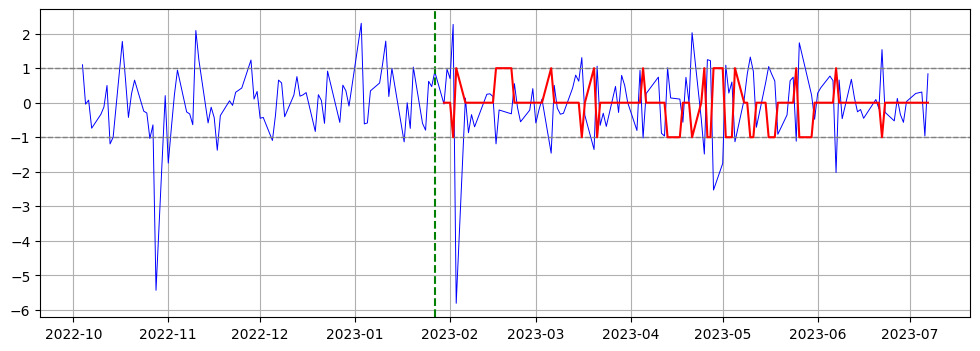

In [530]:
pair = ('AMZN', 'AAPL')
trader = Pairs_Trader(fitter, pair)
trader.run()
trader.plot()


In [531]:
trader.analyse()

{'total_return': 21}

In [481]:
trader.analyse()

{'total_return': 19}

In [475]:
trader.analyse()

{'total_return': 19}

In [ ]:
1) Find cointegrated stocks (returns)
2) estimate gamma on past data (can be found with a VECM model apptrenty in the Pi matrix)